# Evapotranspiración MODIS
_Autor:_    __Jesús Casado__ <br> _Revisión:_ __29/01/2020__ <br>

__Introducción__<br>
Datos de MODIS sobre evapotranspiración en la cuenca del Deva. 
1. Se cargan los datos originales (8 días) y se agregan a diversas frecuencias temporales (mensual y anual). Los datos se muestran en mapas y series.
2. Introducción al análisis de EOFs sobre los datos anteriores.

__Cosas que arreglar__ <br>


__Fuentes__<br>
[Terra: MOD16A2](https://lpdaac.usgs.gov/products/mod16a2v006/)<br>
[Aqua: MYD16A2](https://lpdaac.usgs.gov/products/myd16a2v006/)<br>
[Explicación productos y unidades](https://www.ntsg.umt.edu/project/modis/mod16.php)<br>
***

__Índice__ <br>
__[Datos](#Datos)__<br>
[DEM de la cuenca](#DEM-de-la-cuenca-(ETRS89-UTM30N))<br>
[Evapotranspiración MODIS](#Evapotranspiración-MODIS)<br>

__[Análisis](#Análisis)__<br>
[8 diario](#8-diario)<br>
[Mensual](#Mensual)<br>
[Anual](#Anual)<br>
[EOF](#EOF)<br>

In [1]:
import numpy as np
import pandas as pd

from netCDF4 import Dataset, num2date, date2num
#import h5py
from datetime import datetime
from calendar import monthrange
import time

import os
rutaBase = os.getcwd().replace('\\', '/') + '/'

import geopandas as gpd
import earthpy as et

from eofs.standard import Eof

import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
from pyproj import Proj, transform, CRS
os.environ['PROJ_LIB'] = r'C:\Anaconda3\pkgs\proj4-4.9.3-vc14_5\Library\share'

In [3]:
os.chdir(rutaBase + '../src/')
from funciones_MODIS import *
from funciones_EOF import *
os.chdir(rutaBase)

In [4]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.style.use('dark_background')
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set()
custom_style = {'axes.facecolor': 'k',
                'axes.edgecolor': 'gray',
                'axes.labelcolor': 'white',
                'figure.facecolor': 'k',
                'grid.color': 'gray',
                'text.color': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white',
                "xtick.major.size": 0,
                "ytick.major.size": 0}
sns.set_style(style='darkgrid', rc=custom_style)

***

## Datos

In [5]:
# configuración
var = 'ET'
units = 'kg/m²/8day'
fillValue = [32761, 32767]
factor = 0.1
satellites = ['Terra', 'Aqua']
products = ['MOD16A2', 'MYD16A2']

In [7]:
# ruta y nombre del archivo
rutaExport = rutaBase + '../output/' + var + '/'
filename = 'MODIS_' + var + '_ArcGIS.nc'

In [8]:
if os.path.exists(rutaExport + filename) == False:
    # EXTRAER DATOS
    # -------------
    Data = {sat: {} for sat in satellites}
    for sat, product in zip(satellites, products):
        print('{0}: {1}'.format(sat, product))
        rutaAsc = 'F:/Cartografia/MODIS/' + product + '/'
        MODISfromASC(rutaAsc, product, factor, fillValue)
        Data[sat][var] = MODISfromASC.data
        Data[sat]['dates'] = MODISfromASC.dates
        Data[sat]['Y'] = MODISfromASC.Y
        Data[sat]['X'] = MODISfromASC.X
        print()
        
    # GUARDAR NETCDF
    # --------------
    MODISnc(rutaExport + filename, Data, var, units)

In [9]:
# IMPORTAR NETCDF
# ---------------
# Cargar netcdf con los datos MODIS
ncRead = Dataset(rutaExport + filename, 'r', format='NETCDF4')

# extraer datos en un diccionario
Data = {'Terra': {}, 'Aqua': {}}
for sat, product in zip(['Terra', 'Aqua'], ['MOD16A2', 'MYD16A2']):
    # evapotranspiración
    Data[sat][var] = ncRead[sat][var][::]
    # fechas
    Data[sat]['dates'] = [datetime(1, 1, 1) + timedelta(time) for time in ncRead[sat]['time'][:]]
    # coordenadas
    Data[sat]['X'] = ncRead[sat]['X'][:]
    Data[sat]['Y'] = ncRead[sat]['Y'][:]

ncRead.close()

***
## Análisis
### 8 diario

C:\Anaconda3\envs\test\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
F:\Codigo\GitHub\MODIS\src\funciones_MODIS.py:520: RuntimeWarning: Mean of empty slice
  ax.plot(timex, np.nanmean(datax, axis=(1, 2)), c=colors[c][1], lw=4*lw)


KeyboardInterrupt: 

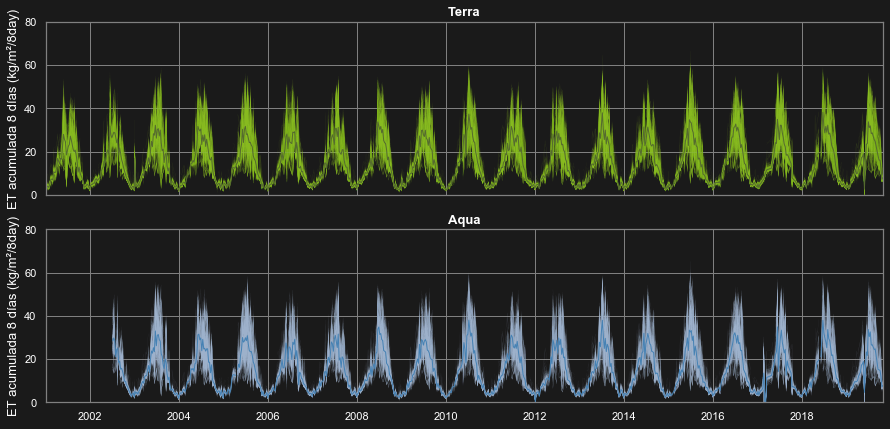

In [10]:
plotMODISseries(Data, var, 'dates', r=20, ylabel=var + ' acumulada 8 días (' + units + ')')
plt.savefig(rutaExport + var + ' 8 días-series.png', dpi=300, tight_layout=True)

In [ ]:
# video of Terra's 8-daily data
animate3Darray(Data['Terra'][var], Data['Terra']['dates'], minmax=[0, 60],
               cblabel=var + ' 8 días (' + units + ')', fps=8,
               pathfile=rutaExport + var + 'deva_MODIS-Terra.mp4')

In [ ]:
# video of Aqua's 8-daily data
animate3Darray(Data['Aqua'][var], Data['Aqua']['dates'], minmax=[0, 60],
               cblabel=var + ' 8 días (units)', fps=8,
               pathfile=rutaExport + var + 'deva_MODIS-Aqua.mp4')

### Mensual
__Medias mensuales__

In [ ]:
# generar medias mensuales
for sat in Data.keys():
    Data[sat]['meanM'] = mediaMensual(Data[sat]['dates'], Data[sat][var])

In [ ]:
ncols = 6
nrows = int(np.ceil(12 / ncols)) * 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.75*ncols, 2.75*nrows))
fig.subplots_adjust(right=0.9)

r = 10
vmin = np.floor(min([np.nanmin(Data[sat]['meanM']) for sat in Data.keys()]) / r) * r
vmax = np.ceil(max([np.nanmax(Data[sat]['meanM']) for sat in Data.keys()]) / r) * r
cmaps = ['su' + units + 'er_r', 'Blues']

for s, (sat, cmap) in enumerate(zip(Data.keys(), cmaps)):
    for k, month in enumerate(range(1, 13)):
        f, c = int(k / ncols) + s * 2, k % ncols
        im = ax[f,c].imshow(Data[sat]['meanM'][k,:,:], cmap=cmap, vmin=vmin, vmax=vmax)
        ax[f,c].set_title(datetime(1900, month, 1).strftime('%b'), fontsize=13)
        ax[f,c].axis('off')
    
    cbar_ax = fig.add_axes([0.925, 0.6 - 0.4 * s, 0.01, 0.2])
    cbar_ax.tick_params(labelsize=12)
    cb = plt.colorbar(im, cax=cbar_ax, orientation='vertical')
    cb.set_label('' + units + '/mes', fontsize=14)
    fig.text(0.1, 0.7  - 0.4 * s, sat, fontsize=14, fontweight='bold', rotation=90,
             verticalalignment='center')
fig.text(0.5, .92, var + ' mensual', fontsize=15, fontweight='bold',
         horizontalalignment='center');
plt.savefig(rutaExport + var + ' mensual-mapas medias.png', dpi=300, tight_layout=True)

In [ ]:
# mostrar la media mensual para cada celda y la media de la cuenca
fig, axes = plt.subplots(ncols=2, figsize=(15, 3.5), sharey=True)

r = 10
ymax = np.ceil(max([np.nanmax(Data[sat]['meanM']) for sat in Data.keys()]) / r) * r
colors = [['yellowgreen', 'darkolivegreen'], ['lightsteelblue', 'steelblue']]

for c, (ax, sat) in enumerate(zip(axes, Data.keys())):
    meanMx = Data[sat]['meanM']
    for i in range(meanMx.shape[1]):
        for j in range(meanMx.shape[2]):
            if np.isnan(meanMx[:,i,j]).sum() == meanMx.shape[0]: # celda vacía
                continue
            else:
                ax.plot(meanMx[:,i,j], lw=.25, c=colors[c][0], alpha=.25)
    ax.plot(np.nanmean(meanMx, axis=(1, 2)), c=colors[c][1], lw=1.2)
    ax.tick_params(labelsize=11)
    ax.set(xlim=(0, 11), ylim=(0, ymax))
    if c == 0:
        ax.set_ylabel(var + ' mensual (' + units + ')', fontsize=13);
    monthnames = [datetime(1900, m, 1).strftime('%b') for m in range(1, 13)]
    ax.set_xticklabels(monthnames[::2])
    ax.set_title(sat, fontsize=13, fontweight='bold')
plt.savefig(rutaExport + var + ' mensual-series medias.png', dpi=300, tight_layout=True)

#### Serie mensual

In [ ]:
# generar series mensuales
for sat in Data.keys():
    Data[sat]['serieM'], Data[sat]['months'] = serieMensual(Data[sat]['dates'], Data[sat][var])

In [ ]:
plotMODISseries(Data, 'serieM', 'months', r=2, ylabel=var + ' mensual (' + units + '/d)')
plt.savefig(rutaExport + var + ' mensual-series.png', dpi=300, tight_layout=True)

In [ ]:
# video of monthly-aggregated Terra's data
animate3Darray(Data['Terra']['serieM'], Data['Terra']['months'], minmax=[0, 10],
               cblabel=var + ' (' + units +')', fps=2, dpi=200,
               pathfile=rutaExport + var + 'deva_MODIS-Terra.mp4')

In [ ]:
animate3Darray(Data['Aqua']['serieM'], Data['Aqua']['months'], minmax=[0, 10],
               cblabel=var + ' (' + units +')', fps=2, dpi=200,
               pathfile=rutaExport + var + 'deva_MODIS-Aqua.mp4')

### Anual
__Media anual__

In [ ]:
for sat in Data.keys():
    Data[sat]['meanA'] = np.nanmean(Data[sat][var], axis=0) * 365 / 8

In [ ]:
# mapa de medias anuales
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

r = 100
vmin = np.floor(min([np.nanmin(Data[sat]['meanA']) for sat in Data.keys()]) / r) * r
vmax = np.ceil(max([np.nanmax(Data[sat]['meanA']) for sat in Data.keys()]) / r) * r

cmaps = ['summer_r', 'Blues']

for c, (ax, sat) in enumerate(zip(axes, Data.keys())):
    im = ax.imshow(Data[sat]['meanA'], cmap=cmaps[c], vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title(sat, fontsize=13, fontweight='bold')
    ax.axis('off');
plt.savefig(rutaExport + var + ' anual-mapas media.png', dpi=300, tight_layout=True)

__Serie anual__

In [ ]:
# generar series anuales
for sat in Data.keys():
    Data[sat]['serieA'], Data[sat]['years'] = serieAnual(Data[sat]['dates'], Data[sat][var])

In [ ]:
plotMODISseries(Data, 'serieA', 'years', r=100, ylabel=var + ' anual (' + units + ')',
                lw=.25, alpha=.25)
plt.savefig(rutaExport + var + ' anual-series.png', dpi=300, tight_layout=True)

In [ ]:
ymin = min([np.min(Data[sat]['years']) for sat in Data.keys()])
ymax = max([np.max(Data[sat]['years']) for sat in Data.keys()])
years = np.arange(ymin, ymax + 1)

ncols = 6
nrows = int(np.ceil(len(years) / ncols)) * 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.75*ncols, 2.75*nrows))
fig.subplots_adjust(bottom=0.1)

r = 100
vmin = np.floor(min([np.nanmin(Data[sat]['serieA']) for sat in Data.keys()]) / r) * r
vmax = np.ceil(max([np.nanmax(Data[sat]['serieA']) for sat in Data.keys()]) / r) * r
cmaps = ['summer_r', 'Blues']

for s, (sat, cmap) in enumerate(zip(Data.keys(), cmaps)):
    for y, year in enumerate(years):
        f, c = int(y / ncols + s * (nrows / 2)), y % ncols
        if year in Data[sat]['years']:
            k = np.where(year == Data[sat]['years'])[0][0]
            im = ax[f,c].imshow(Data[sat]['serieA'][k,:,:], cmap=cmap, vmin=vmin, vmax=vmax)
            ax[f,c].set_title(year, fontsize=13)
            ax[f,c].axis('off')
        else:
            ax[f,c].axis('off')
    
    cbar_ax = fig.add_axes([0.92, 0.6  - .4 * s, 0.01, 0.2])
    cbar_ax.tick_params(labelsize=12)
    cb = plt.colorbar(im, cax=cbar_ax, orientation='vertical')
    cb.set_label('' + units + '/año', fontsize=13)
    fig.text(.1, .7 - .4 * s, sat, fontsize=14, fontweight='bold', rotation=90,
             verticalalignment='center')
fig.text(.5, .92, var + ' anual', fontsize=15, fontweight='bold',
         horizontalalignment='center');
plt.savefig(rutaExport + var + ' anual-mapas.png', dpi=300, tight_layout=True)

## EOF
### Terra

In [ ]:
eofMODIS(Data['Terra']['serieA'], Data['Terra']['Y'], nmodes=4, coordsIn='epsg:25830',
         lons=Data['Terra']['X'], plot='corr')

eofs = eofMODIS.eofs
pcs = eofMODIS.pcs
corr = eofMODIS.correlation
variance = eofMODIS.explainedVariance
plt.savefig(rutaExport + var + ' eofs-Terra anual.png', dpi=300, tight_layout=True)

### Aqua

In [ ]:
eofMODIS(Data['Aqua']['serieA'], Data['Aqua']['Y'], nmodes=4, coordsIn='epsg:25830',
         lons=Data['Aqua']['X'], plot='corr')

eofs = eofMODIS.eofs
pcs = eofMODIS.pcs
corr = eofMODIS.correlation
variance = eofMODIS.explainedVariance
plt.savefig(rutaExport + var + ' eofs-Aqua anual.png', dpi=300, tight_layout=True)

<font color='indianred'>__¡Hay que completar los datos!__ El paquete `eof` elimina las celdas en las que hay algún NaN.